In [1]:
import sys
sys.path.append("..")
from flame_analysis_model import *

from mpi4py import MPI

import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import torch
import torch.optim as optim
import torch.nn as nn
from sklearn.preprocessing import StandardScaler
import torch.nn.functional as F


C:\Users\alexp\Documents\Bachelor Thesis\Code\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Read data

In [2]:
# 1) File path
fname = "./data/h200.f00065"
gname = "./data/h200.f00001"

# Communicator for parallelization
comm = MPI.COMM_WORLD

# 2) Load dataset
ds = SEMDataset(fname, comm=MPI.COMM_WORLD, gname=gname)
print(ds.fld.fields.keys())


2025-10-30 14:38:18,419 - Mesh - INFO - Initializing empty Mesh object.
2025-10-30 14:38:18,419 - Field - INFO - Initializing empty Field object
2025-10-30 14:38:18,420 - pynekread - INFO - Reading file: ./data/h200.f00001
2025-10-30 14:38:18,443 - Mesh - INFO - Initializing Mesh object from x,y,z ndarrays.
2025-10-30 14:38:18,443 - Mesh - INFO - Initializing common attributes.
2025-10-30 14:38:18,445 - Mesh - INFO - Getting vertices
2025-10-30 14:38:18,446 - Mesh - INFO - Getting edge centers
2025-10-30 14:38:18,454 - Mesh - INFO - Facet centers not available for 2D
2025-10-30 14:38:18,455 - Mesh - INFO - Mesh object initialized.
2025-10-30 14:38:18,456 - Mesh - INFO - Mesh data is of type: float64
2025-10-30 14:38:18,456 - Mesh - INFO - Elapsed time: 0.013724100004765205s
2025-10-30 14:38:18,457 - pynekread - INFO - Reading field data
2025-10-30 14:38:18,497 - pynekread - INFO - File read
2025-10-30 14:38:18,498 - pynekread - INFO - Elapsed time: 0.07845709999674s
2025-10-30 14:38:18

In [3]:
# 3) Extract flame front dataframe
scalar_names = [
        "H2","O2","H2O","H","O","OH","HO2","H2O2","N2",
        #Old setup:
        #"heat_release","curvature","stretch_Law","disp_speed_rhoW","disp_speed",
        #"abs_flame_prop_vel","flow_vel_normal","flow_vel_tang","stretch_Poinsot_term",
        #"tangential_strain_Law","nst1_normal_strain","heat_cond_total","heat_cond_normal",
        #"heat_cond_tangential","density_ratio_sigma","vorticity"
]

front = FlameFront2D(ds)

front.make_front_dataframe(
    scalar_name_map=scalar_names,
    sample_mode="progress",
    c_level=0.68,
    tol=0.2,
    include_first_vel_derivs= True,
    include_second_vel_derivs=False,
    include_curvature_derivs=False,
    include_T_derivs=False
)

#Need to have a "chem.yaml" file!
species_list = ["H2", "O2", "H2O", "H", "O", "OH", "HO2", "H2O2", "N2"]
front.add_Le_to_dataset(species_list)
print(front.df.keys())

# 4) Save dataset
front.df.to_csv("flame_front_po_post0.csv", index=False)

2025-10-30 14:38:18,634 - Coef - INFO - Calculating the derivative with respect to physical coordinates
2025-10-30 14:38:18,651 - Coef - INFO - done
2025-10-30 14:38:18,652 - Coef - INFO - Elapsed time: 0.017437300004530698s
2025-10-30 14:38:18,653 - Coef - INFO - Calculating the derivative with respect to physical coordinates
2025-10-30 14:38:18,669 - Coef - INFO - done
2025-10-30 14:38:18,670 - Coef - INFO - Elapsed time: 0.01638960000127554s
2025-10-30 14:38:18,671 - Coef - INFO - Calculating the derivative with respect to physical coordinates
2025-10-30 14:38:18,687 - Coef - INFO - done
2025-10-30 14:38:18,688 - Coef - INFO - Elapsed time: 0.01573389999975916s
2025-10-30 14:38:18,689 - Coef - INFO - Calculating the derivative with respect to physical coordinates
2025-10-30 14:38:18,705 - Coef - INFO - done
2025-10-30 14:38:18,706 - Coef - INFO - Elapsed time: 0.015550700001767837s
Index(['x', 'y', 'u', 'v', 'T', 'c', 'dudx', 'dudy', 'dvdx', 'dvdy', 'H2',
       'O2', 'H2O', 'H', 'O

## Field plots

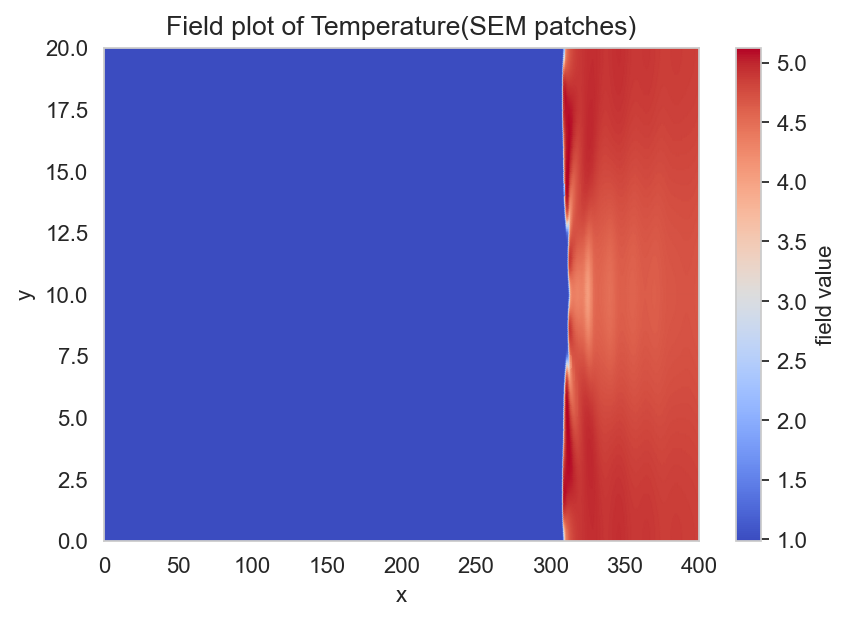

In [4]:
Plot2D.plot_field(ds.msh, ds.T,plot_name="Temperature", mode="sem", cmap="coolwarm")

## Pearson Corellation

In [5]:
Plot2D.print_pearson(front.df, cols=["u","v","T","H2","O2", "Le_def"])

            u    v      T     H2     O2  Le_def
u       1.000 -0.0  0.561 -0.696 -0.396  -0.688
v      -0.000  1.0 -0.000  0.000  0.000   0.000
T       0.561 -0.0  1.000 -0.852 -0.926  -0.697
H2     -0.696  0.0 -0.852  1.000  0.644   0.959
O2     -0.396  0.0 -0.926  0.644  1.000   0.411
Le_def -0.688  0.0 -0.697  0.959  0.411   1.000


## Pairplot

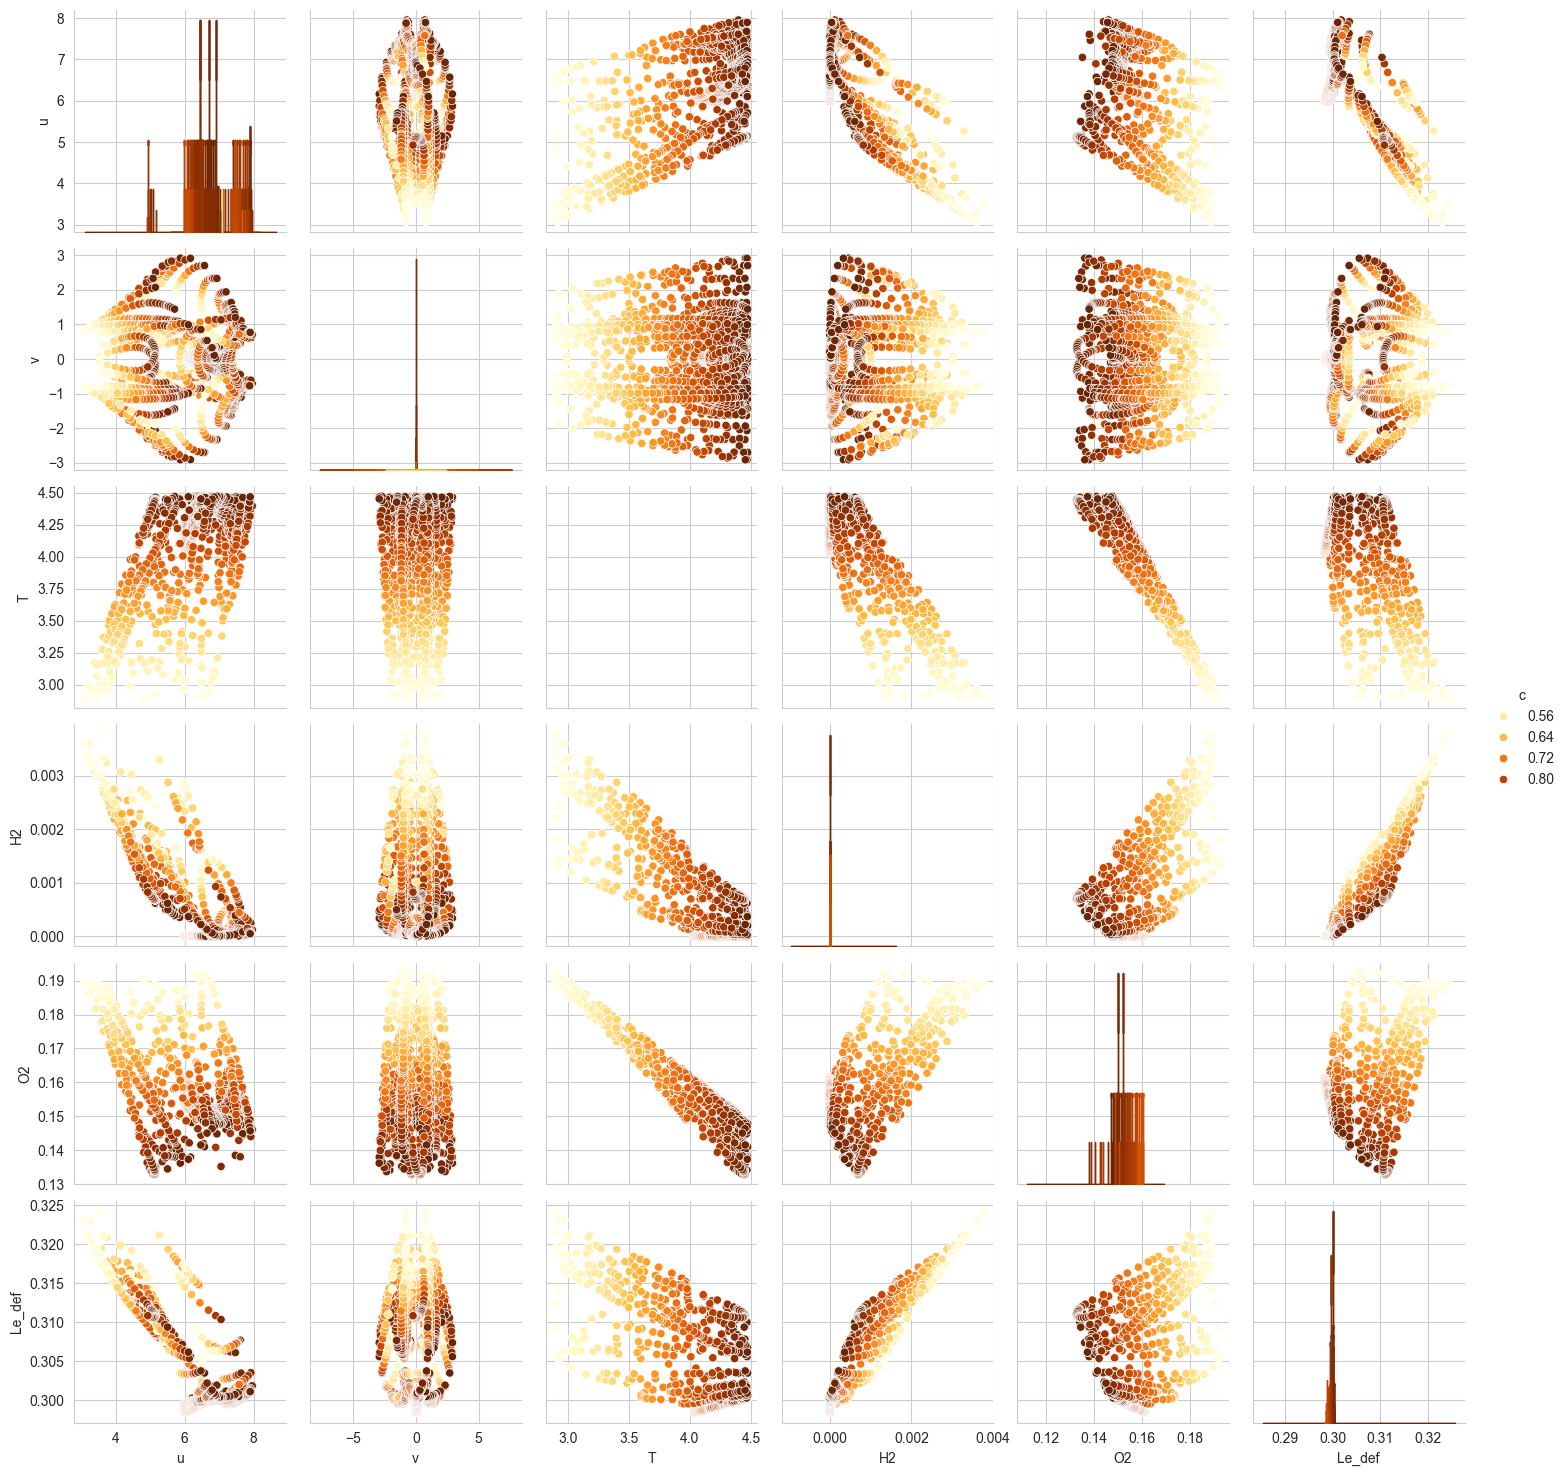

In [6]:
#Plot2D.heat_map(front.df, cols =
#       ["u","v","T","H2","O2", "Le_def"])

cols = ["u","v","T","H2","O2","Le_def"]
sns.pairplot(
    front.df,
    vars=cols,
    hue="c",
    palette="YlOrBr",
    #diag_kind="hist"
    #diag_kws=dict(bins=40, edgecolor=None, alpha=0.8),
);



## NN for velocity prediction

Epoch 1/130
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 2.5681 - val_loss: 0.6226
Epoch 2/130
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5817 - val_loss: 0.4308
Epoch 3/130
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3891 - val_loss: 0.2965
Epoch 4/130
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2833 - val_loss: 0.2241
Epoch 5/130
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2387 - val_loss: 0.2660
Epoch 6/130
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2240 - val_loss: 0.1963
Epoch 7/130
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2336 - val_loss: 0.2226
Epoch 8/130
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2038 - val_loss: 0.1930
Epoch 9/130
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1922 - val_loss: 0.1927
Epoch 10/130
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1928 - val_loss: 0.1751
Epoch 11/130
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1869 - val_loss: 0.2033
Epoch 12/130
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2

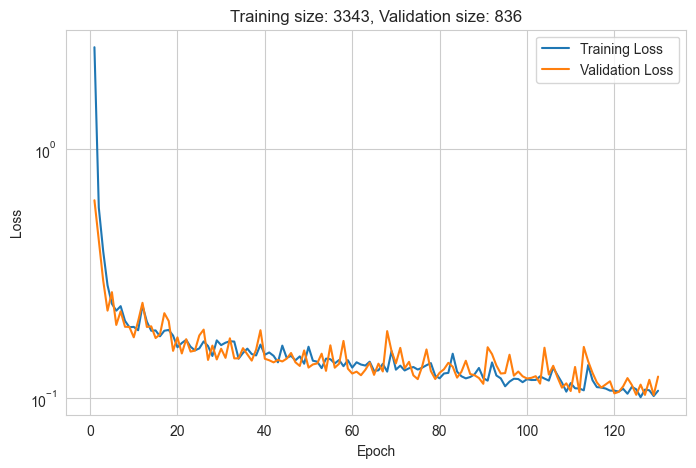

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


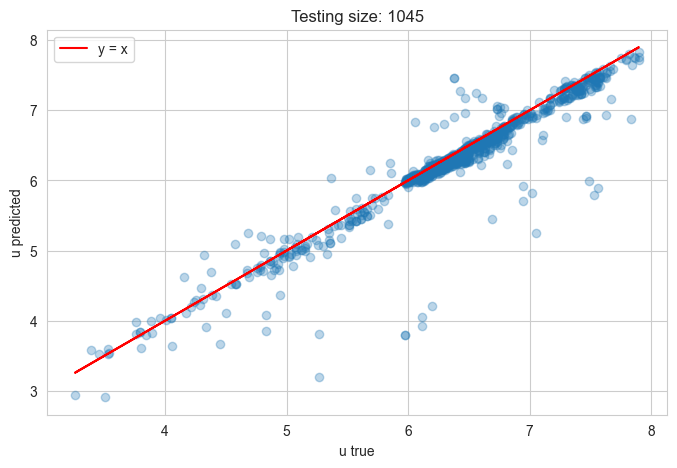

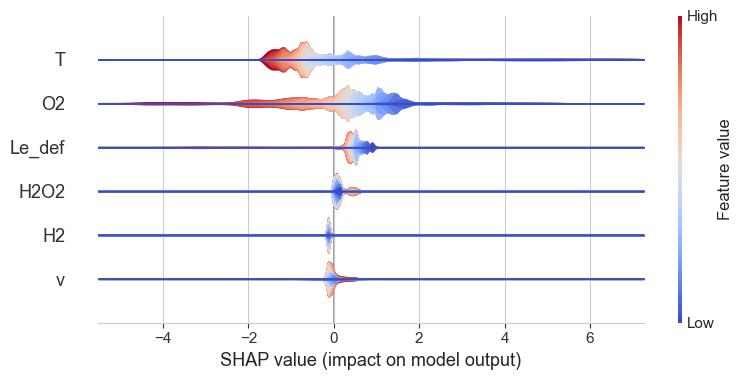

In [7]:
feature_names = ["v","T","H2","O2", "H2O2", "Le_def"]

""""
Old setup:
[ 'curvature' ,'stretch_Law',
        'heat_cond_normal', 'heat_cond_tangential',
        'tangential_strain_Law', 'Le_def', 'vorticity']
"""

ml = MachineLearningModel(features=feature_names, target="u", test_size=0.2, n_epoch= 130)
ml.prepare_data(front.df).build_model().train()
ml.plot_loss()
ml.evaluate()
ml.shap_summary()

